In [1]:
import matplotlib.pyplot as plt
import numpy as np
import teneva
from time import perf_counter as tpc
np.random.seed(42)

In [2]:
e_qtt = 1.E-3

def cross_matrix_spec(f, I1, I2):
    n1 = I1.shape[0]
    n2 = I2.shape[0]
    
    q1 = int(np.log2(n1))
    q2 = int(np.log2(n2))
    q = q1 + q2
    
    if 2**q1 != n1 or 2**q2 != n2:
        raise NotImplementedError('Mode size and rank should be power of 2')
    
    def func(I):
        I_base = []
        for i in I:
            i1 = teneva.ind_qtt_to_tt(i[:q1], q1)[0]
            i2 = teneva.ind_qtt_to_tt(i[q1:], q2)[0]
            i1_base = I1[i1]
            i2_base = I2[i2]
            I_base.append(np.hstack((i1_base, i2_base)))
        I_base = np.array(I_base, dtype=int)
        return f(I_base)
    
    info = {}
    Y = teneva.tensor_rand([2]*q, 1)
    Y = teneva.cross(func, Y, e=e_qtt, cache={}, info=info, log=False)
    Y = teneva.full(Y).reshape(n1, n2, order='F')
    
    return Y, info['m']

In [3]:
def _ones(k, m=1):
    return np.ones((k, m), dtype=int)

In [4]:
def _reshape(A, n, order='F'):
    return np.reshape(A, n, order=order)

In [5]:
def _func_new(f, Ig, Ir, Ic, info, cache=None):
    if cache is not None:
        raise NotImplementedError('Cache is not supported in fast cross')
    
    n = Ig.shape[0]
    r1 = Ir.shape[0] if Ir is not None else 1
    r2 = Ic.shape[0] if Ic is not None else 1

    if info['m_max'] is not None and info['m'] + r1*n*r2 > info['m_max']:
        return None

    if Ic is not None:
        I2 = Ic
    else:
        I = np.kron(np.kron(_ones(r2), Ig), _ones(r1))
        Ir_ = np.kron(_ones(n * r2), Ir)
        I = np.hstack((Ir_, I))
        
        y = f(I)
        info['m'] += len(y)
        
        return _reshape(y, (r1, n, r2))

    I1 = np.kron(Ig, _ones(r1))
    if Ir is not None:
        I1 = np.hstack((np.kron(_ones(n), Ir), I1))
    
    y, m = cross_matrix_spec(f, I1, I2)
    info['m'] += m
    
    return _reshape(y, (r1, n, r2))

In [6]:
def func_cross(func, Y0, m, with_info=False, is_new=False):
    func.clear()
    
    func.prep(Y0)
    func.cross(m, dr_max=0, cache=None, func=_func_new if is_new else None)
    
    if is_new:
        func.method += '-FAST'
    
    func.check()
    if with_info:
        func.info(f'm = {func.m:7.1e}')
    
    return {'t': func.t, 'm': func.m, 'e': func.e_tst_ind}

In [7]:
d = 10               # Dimension
n = 1024             # Grid size
r = 4                # TT-rank
with_info = True     # If true, then logs will be printed

print(f'One sweep is : {d * n * r * r:-7.1e}')

One sweep is: 1.6e+05


In [8]:
m_list = [5.E+4, 6.E+4, 7.E+4, 8.E+4, 9.E+4, 1.E+5, 2.E+5, 3.E+5, 4.E+5, 5.E+5]
result = {}

for m in m_list:
    for func in teneva.func_demo_all(d):
        func.set_grid(n, kind='uni')
        func.build_tst_ind(1.E+3)
        
        Y0 = teneva.tensor_rand(func.n, r)
        
        data_old = func_cross(func, Y0, m, with_info)
        data_new = func_cross(func, Y0, m, with_info, is_new=True)
        
        if not func.name in result:
            result[func.name] = {'old': [], 'new': []}
        
        result[func.name]['old'].append(data_old)
        result[func.name]['new'].append(data_new)
        
        if with_info:
            print()

Ackley          [CRO          ] > error: 1.0e+00 | rank:  4.0 | time:   1.709 | m = 3.7e+04
Ackley          [CRO-FAST     ] > error: 3.5e-03 | rank:  4.0 | time:   3.385 | m = 3.6e+04

Alpine          [CRO          ] > error: 1.0e+00 | rank:  3.5 | time:   0.678 | m = 3.7e+04
Alpine          [CRO-FAST     ] > error: 2.6e-04 | rank:  2.1 | time:   3.435 | m = 3.6e+04

Dixon           [CRO          ] > error: 1.0e+00 | rank:  4.0 | time:   0.710 | m = 3.7e+04
Dixon           [CRO-FAST     ] > error: 1.2e-14 | rank:  3.4 | time:   3.978 | m = 4.1e+04

Exponential     [CRO          ] > error: 1.0e+00 | rank:  3.3 | time:   0.690 | m = 3.7e+04
Exponential     [CRO-FAST     ] > error: 1.8e-11 | rank:  2.1 | time:   3.432 | m = 3.4e+04

Grienwank       [CRO          ] > error: 1.0e+00 | rank:  3.8 | time:   0.678 | m = 3.7e+04
Grienwank       [CRO-FAST     ] > error: 4.6e-13 | rank:  3.3 | time:   3.524 | m = 3.4e+04

Michalewicz     [CRO          ] > error: 1.0e+00 | rank:  3.5 | time:   0.6

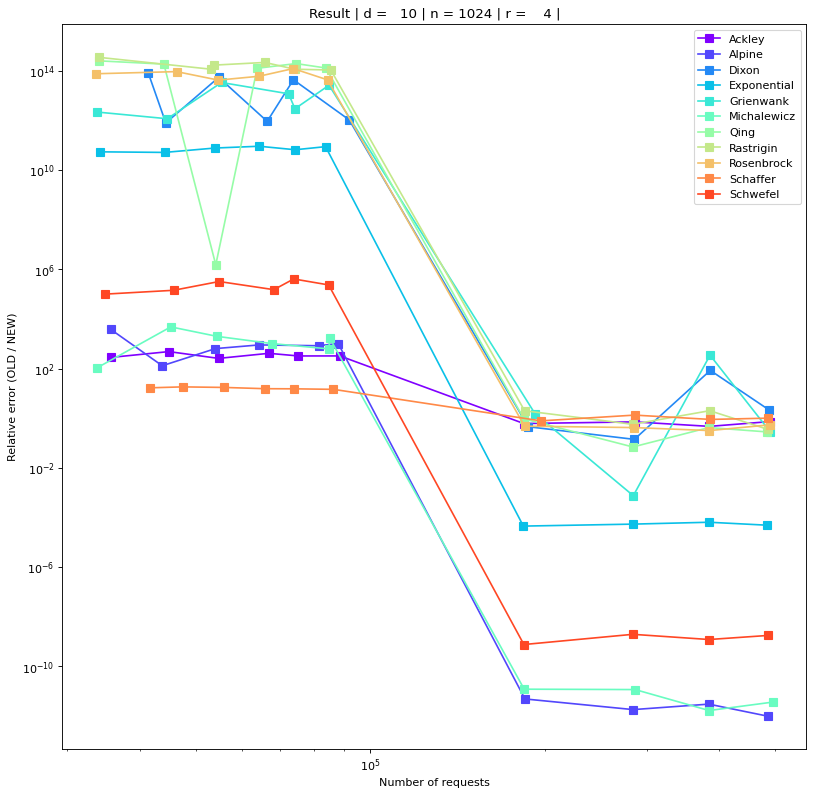

In [12]:
colors = plt.cm.rainbow(np.linspace(0, 1, 12))

plt.figure(figsize=(12, 12), dpi=80)

for i, (name, data) in enumerate(result.items()):
    m_old = [item['m'] for item in data['old']]
    e_old = np.array([item['e'] for item in data['old']])
    
    m_new = [item['m'] for item in data['new']]
    e_new = np.array([item['e'] for item in data['new']])
    
    plt.plot(m_new, e_old/e_new, '-' , color=colors[i], marker='s', markersize=8, label=name)

plt.title(f'Result | d = {d:-4d} | n = {n:-4d} | r = {r:-4d} |')
plt.xlabel('Number of requests')
plt.ylabel('Relative error (OLD / NEW)')
plt.semilogx()
plt.semilogy()
plt.legend(loc='best')
plt.show()

---